## About the project
The [UBC EWS SkySpark platform](https://skyspark.energy.ubc.ca), managed by Energy and Water Services (EWS) of the University of British Columbi (UBC), collects data on weather and UBC buildings every 15 minutes. UBC Urban Data Lab (UDL) mirrored the SkySpark database into an InfluxDB instance to increase the accessibility and usability of the data.

UDL provides public users READ access to the InfluxDB with the credentials

`host='206.12.92.81',port=8086, username='public', password='public', database='SKYSPARK'`

You can access this InfluxDB database from [InfluxDB command line interface](https://docs.influxdata.com/influxdb/v1.7/tools/shell/) or [open-source InfluxDB API client libraries](https://docs.influxdata.com/influxdb/v1.7/tools/api_client_libraries/). This notebook demonstrates  querying the InfluxDB database using the `influxdb` Python module.

Please [contact UDL](https://urbandatalab.io/) if you have any questions.

## Dependecies

```python
# -----------------------------------------------
# Querying SkySpark data on UDL's InfluxDB database and performing analysis in pandas DataFrame
# Author: Jiachen Wei, UBC Urban Data Lab
# Date: Sept 2020
# -----------------------------------------------
#Dependencies of the influxdb Python module
#HTTP library for human beings
! pip install requests
#writing from and reading to DataFrames
! pip install pandas
#to create and manage the documentation
! pip install Sphinx 
#to auto-discover tests
! pip install nose
#to mock tests
! pip install mock

#to install, upgrade or uninstall influxdb
! pip install influxdb
#! pip install --upgrade influxdb
#! pip uninstall influxdb
```

In [1]:
import pandas as pd
import influxdb
from datetime import timezone, datetime
import pytz
import matplotlib.pyplot as plt
%matplotlib inline
import certifi

## Connecting and Querying UDL's InfluxDB

In [2]:
#DataFrameClient can write pandas DataFrames into influx, or read data into a pandas DataFrame
client = influxdb.DataFrameClient(host='206.12.92.81',port=8086, 
                                  username='public', password='public',database='SKYSPARK')
for d in client.get_list_measurements():
    print('measurement:',d['name']) #d is a dictionary; 'name' is the key; measurement name is the value

measurement: END_USE
measurement: POINT
measurement: READINGS
measurement: UBC_EWS


Measurement `READINGS` contains timestamps, reading values, uniqueID, and basic information ('siteRef','groupRef','equipRef','navName','typeRef') for each data point.

Measurement `POINT` contains uniqueID and tagging information (up to 155 fields, field omitted if null) for each data point. Refer to [Haystack tags](https://www.project-haystack.org/tag) and [this list of HVAC acronyms](https://www.abraxasenergy.com/energy-resources/toolbox/hvac-acronyms/).

Querying an entire measurement should be avoided.

```python
cli.query(query='select * from READINGS')
#To return a large chunck of data can take very long or break the connection.
```

You can specify **'siteRef','groupRef','equipRef','navName','typeRef'** ([tags key](https://docs.influxdata.com/influxdb/v1.8/concepts/) in InfluxDB, order can vary) in the where clause of the query. For example,
```python
where_params = {'siteRef': 'CIRS',
                'groupRef':'CIRS Air Systems',
                'equipRef':'AHU-02',
                'navName':'Discharge Air Temp',
                'typeRef':'CIRS_AHU2_SUPPLY_AIR_T'}
```
Let's assume we want to query data on the Pharmacy buidling `'siteRef': 'Pharmacy'` and explore the other tag values.

In [3]:
#Use bind_params in a query
query = 'select * from READINGS where siteRef=$siteRef and time > now() - 1h'
where_params = {'siteRef': 'Pharmacy'}
result = client.query(query = query, bind_params = where_params, 
                      chunked=True, chunk_size=10000)  #Use chunked responses from InfluxDB
                    # Try restart Python kernel and change chunk_size if it fails
df=result['READINGS']
print("Time zone in InfluxDB:",df.index.tz)
my_timezone = pytz.timezone('Canada/Pacific')
df.index=df.index.tz_convert(my_timezone)
print("Converted to",my_timezone,"in dataframe")
print("Dataframe memory usage in bytes:",f"{df.memory_usage().values.sum():,d}")
pd.options.display.max_rows = 6
df

Time zone in InfluxDB: UTC
Converted to Canada/Pacific in dataframe
Dataframe memory usage in bytes: 3,978,392


,equipRef,groupRef,navName,siteRef,typeRef,uniqueID,unit,val_bool,val_num,val_str
2020-09-18 14:40:01-07:00,Rm 4320 VAV-4S044,Pharmacy Floor 4,Discharge Air Damper Open Cmd,Pharmacy,VAV_4S044_Dmp_Open,r:p:ubcv:r:2391c835-b99953a0 Pharmacy Rm 4320 ...,omit,True,NaN,None
2020-09-18 14:40:01-07:00,Rm 5122 VAV-5S001,Pharmacy Floor 5,Zone Temp Effective Sp,Pharmacy,VAV_5S001_RT_SP,r:p:ubcv:r:236c8cfc-def7e544 Pharmacy Rm 5122 ...,°C,None,21.000000,None
2020-09-18 14:40:02-07:00,LEF-2,Pharmacy Air Systems,Exhaust Air Flow,Pharmacy,EF2_AFLW,r:p:ubcv:r:236c8a57-fdb2afe9 Pharmacy LEF-2 EF...,ft/min,None,784.859619,None
...,...,...,...,...,...,...,...,...,...,...
2020-09-18 15:04:14-07:00,Water Submeters WM-9,Pharmacy Utilities,WM9_BLDG_SPT,Pharmacy,WM9_BLDG_SPT,r:p:ubcv:r:236c8a84-09969b12 Pharmacy Water Su...,L,None,0.000000,None
2020-09-18 15:04:14-07:00,Water Submeters WM-9,Pharmacy Utilities,WM9_BLDG_SPT_LAST,Pharmacy,WM9_BLDG_SPT_LAST,r:p:ubcv:r:236c8a84-0ae5cf2b Pharmacy Water Su...,L,None,0.000000,None
2020-09-18 15:04:14-07:00,Water Submeters WM-9,Pharmacy Utilities,Water Flow,Pharmacy,WM9_BLDG_FLOW,r:p:ubcv:r:236c8a84-be2cfaa0 Pharmacy Water Su...,L,None,0.000000,None


## Exploring the Queried Data

In [4]:
#To view the unique values in a column
col = 'groupRef'
print("Unique values in column",col)
#Note that groupRef=weatherRef has null values for siteRef
print(sorted(df[col].fillna(value="None").unique()))

Unique values in column groupRef
['Pharmacy Air Systems', 'Pharmacy Floor 0', 'Pharmacy Floor 1', 'Pharmacy Floor 2', 'Pharmacy Floor 3', 'Pharmacy Floor 4', 'Pharmacy Floor 5', 'Pharmacy Floor 6', 'Pharmacy Hydronic Systems', 'Pharmacy Roof', 'Pharmacy Utilities']


In [5]:
#count values in each end-use group
pd.options.display.max_rows = 25
df.groupby(by=['groupRef']).size().to_frame('count')

,count
groupRef,
Pharmacy Air Systems,7069
Pharmacy Floor 0,4705
Pharmacy Floor 1,1805
Pharmacy Floor 2,3207
Pharmacy Floor 3,5246
Pharmacy Floor 4,4135
Pharmacy Floor 5,4599
Pharmacy Floor 6,4485
Pharmacy Hydronic Systems,5419


In [6]:
#Apply filters from what we explored above
fltr = {'groupRef':'Pharmacy Air Systems',
        'equipRef':'AHU-01'}
df1 = df
for k in fltr:
    df1= df1[(df1[k] == fltr[k])]
print('Filter applied:',fltr)
df1 

Filter applied: {'groupRef': 'Pharmacy Air Systems', 'equipRef': 'AHU-01'}


,equipRef,groupRef,navName,siteRef,typeRef,uniqueID,unit,val_bool,val_num,val_str
2020-09-18 14:43:02-07:00,AHU-01,Pharmacy Air Systems,AHU1_2_7_9_CLG_DP,Pharmacy,AHU1_2_7_9_CLG_DP,r:p:ubcv:r:236c8a88-2d05ef14 Pharmacy AHU-01 A...,kPa,None,107.596697,None
2020-09-18 14:43:02-07:00,AHU-01,Pharmacy Air Systems,AHU1_2_HTG_DP,Pharmacy,AHU1_2_HTG_DP,r:p:ubcv:r:236c8a88-0a4ed3d3 Pharmacy AHU-01 A...,kPa,None,48.515829,None
2020-09-18 14:43:02-07:00,AHU-01,Pharmacy Air Systems,AHU1_2_HTG_DP_BPV_SP,Pharmacy,AHU1_2_HTG_DP_BPV_SP,r:p:ubcv:r:236c8a88-c05b7874 Pharmacy AHU-01 A...,kPa,None,49.349998,None
2020-09-18 14:43:02-07:00,AHU-01,Pharmacy Air Systems,AHU1_EMEG_PWR_MODE,Pharmacy,AHU1_EMEG_PWR_MODE,r:p:ubcv:r:236c8a99-aa5bbb00 Pharmacy AHU-01 A...,omit,False,NaN,None
2020-09-18 14:43:02-07:00,AHU-01,Pharmacy Air Systems,AHU1_FZ,Pharmacy,AHU1_FZ,r:p:ubcv:r:236c8a99-03adb6e7 Pharmacy AHU-01 A...,omit,False,NaN,None
...,...,...,...,...,...,...,...,...,...,...
2020-09-18 15:04:14-07:00,AHU-01,Pharmacy Air Systems,Leaving Hot Water Temp,Pharmacy,AHU1_HWST,r:p:ubcv:r:236c8a99-f2678603 Pharmacy AHU-01 A...,°C,None,27.789058,None
2020-09-18 15:04:14-07:00,AHU-01,Pharmacy Air Systems,Outside Air Damper,Pharmacy,AHU1_OAD_ES,r:p:ubcv:r:236c8a99-fc492df3 Pharmacy AHU-01 A...,omit,True,NaN,None
2020-09-18 15:04:14-07:00,AHU-01,Pharmacy Air Systems,Outside Air Damper Cmd,Pharmacy,AHU1_OAD,r:p:ubcv:r:236c8a99-508fa30c Pharmacy AHU-01 A...,omit,True,NaN,None
2020-09-18 15:04:14-07:00,AHU-01,Pharmacy Air Systems,Zone Relative Humidity Sp,Pharmacy,AHU1_2_AVG_RH_SP,r:p:ubcv:r:236c8a98-344e40bf Pharmacy AHU-01 A...,%RH,None,45.000000,None


You can also apply filters like this
```python
df[(df['siteRef'] == 'CIRS') &
   (df['groupRef']=='CIRS Air Systems') &
   (df['equipRef']=='AHU-02') &
   (df['navName']=='CIRS_AHU2_NSB_BV')]
#Note that some data streams can have only one value as the data did not change over a long time.
```

## Visualizing the Queried Data

In [7]:
#Make a hierarchical DataFrame
df2 = df
df2.index.name = 'time'
df2.reset_index(inplace=True)
df2.set_index(keys=['siteRef','groupRef','navName','equipRef','typeRef','uniqueID','time'], inplace=True) 
                #'time' is set as the last index so the filtered dataframe has unique indexes
df2.sort_index(inplace=True) #sort the index
#Filter the hierarchical DataFrame
fltr=['Pharmacy','Pharmacy Air Systems','Discharge Air Temp']
    #In the same order as the keys in df.set_index()
    #The specified columns ['siteRef','groupRef','navName'] will not be shown
for v in fltr:
    df2 = df2.loc[v] 
pd.options.display.max_rows = 10
df2

unit  \
equipRef typeRef   uniqueID                                           time                             
AHU-06   AHU6_SAT  r:p:ubcv:r:20d5d095-6a9dc271 Pharmacy AHU-06 AH... 2020-09-18 14:43:02-07:00   °C   
                                                                      2020-09-18 14:45:09-07:00   °C   
                                                                      2020-09-18 14:50:09-07:00   °C   
                                                                      2020-09-18 14:52:11-07:00   °C   
                                                                      2020-09-18 14:57:11-07:00   °C   
...                                                                                              ...   
AHU-18   AHU18_SAT r:p:ubcv:r:236c8a6c-a3274bf3 Pharmacy AHU-18 AH... 2020-09-18 14:52:11-07:00   °C   
                                                                      2020-09-18 14:57:11-07:00   °C   
                                                                      2020-09-18 14:59:14-07:00   °C   
                                                                      2020-09-18 15:00:00-07:00   °C   
                                                                      2020-09-18 15:04:14-07:00   °C   

                                                                                                val_bool  \
equipRef typeRef   uniqueID                                           time                                 
AHU-06   AHU6_SAT  r:p:ubcv:r:20d5d095-6a9dc271 Pharmacy AHU-06 AH... 2020-09-18 14:43:02-07:00     None   
                                                                      2020-09-18 14:45:09-07:00     None   
                                                                      2020-09-18 14:50:09-07:00     None   
                                                                      2020-09-18 14:52:11-07:00     None   
                                                                      2020-09-18 14:57:11-07:00     None   
...                                                                                                  ...   
AHU-18   AHU18_SAT r:p:ubcv:r:236c8a6c-a3274bf3 Pharmacy AHU-18 AH... 2020-09-18 14:52:11-07:00     None   
                                                                      2020-09-18 14:57:11-07:00     None   
                                                                      2020-09-18 14:59:14-07:00     None   
                                                                      2020-09-18 15:00:00-07:00     None   
                                                                      2020-09-18 15:04:14-07:00     None   

                                                                                                   val_num  \
equipRef typeRef   uniqueID                                           time                                   
AHU-06   AHU6_SAT  r:p:ubcv:r:20d5d095-6a9dc271 Pharmacy AHU-06 AH... 2020-09-18 14:43:02-07:00  18.195803   
                                                                      2020-09-18 14:45:09-07:00  19.626665   
                                                                      2020-09-18 14:50:09-07:00  19.626665   
                                                                      2020-09-18 14:52:11-07:00  19.626665   
                                                                      2020-09-18 14:57:11-07:00  19.626665   
...                                                                                                    ...   
AHU-18   AHU18_SAT r:p:ubcv:r:236c8a6c-a3274bf3 Pharmacy AHU-18 AH... 2020-09-18 14:52:11-07:00  17.197650   
                                                                      2020-09-18 14:57:11-07:00  17.180163   
                                                                      2020-09-18 14:59:14-07:00  17.172983   
                                                                      2020-09-18 15:00:00-07:00  17.170357   
                  

C:\Users\jwei06\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


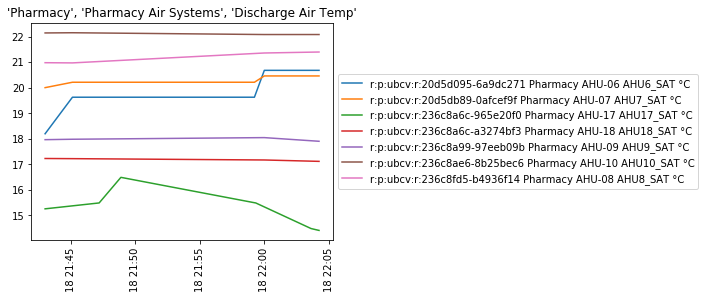

In [8]:
#Visualize the values in each ['equipRef','typeRef'] group
#Columna name 'val_num' indicates the data is in numerical format (float)
fig = plt.figure()
ax = fig.add_subplot(111)
#Iterate through the index (groups) of df2 
for gname,dfm in df2.reset_index('time').groupby(level=['uniqueID']):
    #gname is a touple and dfm is a dataframe
    if len(dfm['unit'].unique()) != 1:        
        raise Exception("The data stream "+ str(gname) +" has not one singe unit "+ str(dfm['unit'].unique()))
    ax.plot(dfm['time'].values,  #index 'time' has been reset to a column
            dfm['val_num'], #might need to use .fillna()
            label=str(gname)+" "+dfm['unit'].unique()[0])
# Shrink current axis by 10%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation='vertical')
plt.title(str(fltr)[1:-1])
plt.show()

## Querying Point Information
Query more information (from the `POINT` measurement) of a specific data point.

In [9]:
#View the 'uniqueID' values in the visualization above
df2.index.unique(level=2)

Index(['r:p:ubcv:r:20d5d095-6a9dc271 Pharmacy AHU-06 AHU6_SAT',
       'r:p:ubcv:r:20d5db89-0afcef9f Pharmacy AHU-07 AHU7_SAT',
       'r:p:ubcv:r:236c8fd5-b4936f14 Pharmacy AHU-08 AHU8_SAT',
       'r:p:ubcv:r:236c8a99-97eeb09b Pharmacy AHU-09 AHU9_SAT',
       'r:p:ubcv:r:236c8ae6-8b25bec6 Pharmacy AHU-10 AHU10_SAT',
       'r:p:ubcv:r:236c8a6c-965e20f0 Pharmacy AHU-17 AHU17_SAT',
       'r:p:ubcv:r:236c8a6c-a3274bf3 Pharmacy AHU-18 AHU18_SAT'],
      dtype='object', name='uniqueID')

In [10]:
#Query the POINT measurement for more information on a specific data point
query = 'select * from POINT where id=$uniqueID'
where_params = {'uniqueID':'r:p:ubcv:r:236c8a6c-965e20f0 Pharmacy AHU-17 AHU17_SAT'}
result = client.query(query = query, bind_params = where_params)
                    # Try restarting Python kernel and specifying chunk_size if it fails
result['POINT']

,air,bacnetConnRef,bacnetHis,bacnetPoint,bmsName,connRef,disMacro,discharge,equipRef,esc,...,navName,objectId,point,sensor,siteRef,tagTableRef,temp,tlName,tz,unit
2020-09-09 00:53:14+00:00,m:,r:p:ubcv:r:236bb200-176f7cdc PHARMA PHARM_AHU1...,s:TL44,m:,s:AHU17_SAT,r:p:ubcv:r:236bb200-176f7cdc PHARMA PHARM_AHU1...,s:$equipRef $bmsName,m:,r:p:ubcv:r:243524ef-679124fd Pharmacy AHU-17,m:,...,s:Discharge Air Temp,s:AI2104,m:,m:,r:p:ubcv:r:20545206-9300bfc5 Pharmacy,r:p:ubcv:r:24c508d8-1a2e5947 .+_SAT(_MUX)?(_TL)?,m:,s:AHU17_SAT_TL,s:Los_Angeles,s:°C


## Querying Weather Data

In [11]:
#Weather information
query = 'select * from READINGS where groupRef=$groupRef and time > now() - 2h'
where_params = {'groupRef': 'weatherRef'}
result = client.query(query = query, bind_params = where_params, 
                      chunked=True, chunk_size=10000)  #Use chunked responses from InfluxDB
                    # Try restart Python kernel and change chunk_size if it fails
weather=result['READINGS']
print("Time zone in InfluxDB:",weather.index.tz)
my_timezone = pytz.timezone('Canada/Pacific')
weather.index=weather.index.tz_convert(my_timezone)
print("Converted to",my_timezone,"in dataframe")
print("Dataframe memory usage in bytes:",f"{weather.memory_usage().values.sum():,d}")
pd.options.display.max_rows = 5

#To see what's in the data
#weather.groupby(by=['groupRef','typeRef']).size().to_frame('count')
#To view a specific type of weather data
weather[weather.typeRef=='UBC Condition']

Time zone in InfluxDB: UTC
Converted to Canada/Pacific in dataframe
Dataframe memory usage in bytes: 7,680


,groupRef,typeRef,uniqueID,unit,val_bool,val_num,val_str
2020-09-18 13:41:05-07:00,weatherRef,UBC Condition,r:p:ubcv:r:233d1e7c-085e7ad0 UBC Condition,omit,None,NaN,s:cloudy
2020-09-18 13:46:05-07:00,weatherRef,UBC Condition,r:p:ubcv:r:233d1e7c-085e7ad0 UBC Condition,omit,None,NaN,s:cloudy
...,...,...,...,...,...,...,...
2020-09-18 14:59:26-07:00,weatherRef,UBC Condition,r:p:ubcv:r:233d1e7c-085e7ad0 UBC Condition,omit,None,NaN,s:cloudy
2020-09-18 15:04:26-07:00,weatherRef,UBC Condition,r:p:ubcv:r:233d1e7c-085e7ad0 UBC Condition,omit,None,NaN,s:cloudy
